# Brain Tumor Classification - EfficientNet-B0 Training

This notebook trains an EfficientNet-B0 model using both the original and external datasets with enhanced augmentation and optimization techniques:

- **AdamW Optimizer** with differential learning rates
- **ReduceLROnPlateau Scheduler**
- **Label Smoothing**
- **Data Loader Optimizations** (num_workers, pin_memory)


In [10]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms, models
from copy import deepcopy
import matplotlib.pyplot as plt
from custom_transforms import AddGaussianNoise

# M2 MacBook: Use MPS if available, else CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: MPS (Apple Silicon GPU)")
    pin_memory = False  # Not supported on MPS yet
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device: CUDA")
    pin_memory = True
else:
    device = torch.device("cpu")
    print("Using device: CPU")
    pin_memory = False

print(f"PyTorch version: {torch.__version__}")

Using device: MPS (Apple Silicon GPU)
PyTorch version: 2.8.0


In [11]:
from pathlib import Path

BASE_DIR = Path.cwd().resolve()
while not (BASE_DIR / "data").exists() and BASE_DIR.parent != BASE_DIR:
    BASE_DIR = BASE_DIR.parent

data_dir = BASE_DIR / "data" / "Brain_Tumor_Dataset" / "Training"
external_data_dir = (
    BASE_DIR / "data" / "Brain_Tumor_Dataset" / "external_dataset" / "training"
)


In [12]:
# Data Augmentation with RandAugment
# RandAugment provides automated, strong augmentation policies
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandAugment(num_ops=2, magnitude=9), # [NEW] Strong automated augmentation
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

print("Data transformations defined (RandAugment enabled).")

Data transformations defined (RandAugment enabled).


In [13]:
# Load Datasets
print("Loading datasets...")
dataset1_train = datasets.ImageFolder(root=data_dir, transform=train_tf)
dataset1_val = datasets.ImageFolder(root=data_dir, transform=val_tf)

try:
    dataset2_train = datasets.ImageFolder(root=external_data_dir, transform=train_tf)
    dataset2_val = datasets.ImageFolder(root=external_data_dir, transform=val_tf)

    full_train = ConcatDataset([dataset1_train, dataset2_train])
    full_val = ConcatDataset([dataset1_val, dataset2_val])
    print(f"Combined dataset loaded.")
except Exception as e:
    print(f"Could not load external dataset: {e}")
    full_train = dataset1_train
    full_val = dataset1_val

class_names = dataset1_train.classes
print("Classes:", class_names)
print("Total samples:", len(full_train))

Loading datasets...
Combined dataset loaded.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total samples: 14158


In [14]:
# Create Data Loaders with Split
indices = list(range(len(full_train)))
np.random.shuffle(indices)
split = int(np.floor(0.2 * len(full_train)))
train_idx, val_idx = indices[split:], indices[:split]

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

# Optimization: num_workers=2 (adjust based on CPU cores), pin_memory=True for faster transfer to GPU
train_loader = DataLoader(
    full_train,
    batch_size=32,
    sampler=train_sampler,
    num_workers=2,
    pin_memory=pin_memory,
    drop_last=True, # Prevent batch size of 1 for BatchNorm stability
)
val_loader = DataLoader(
    full_val, batch_size=32, sampler=val_sampler, num_workers=2, pin_memory=pin_memory
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 353
Validation batches: 89


In [15]:
# Model Setup - EfficientNet-B0 with Freezing
num_classes = len(class_names)

# Load EfficientNet-B0
base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# 1. Freeze the ENTIRE features block
for param in base.features.parameters():
    param.requires_grad = False

# 2. Reconstruct Classifier Head with Strong Regularization
in_features = base.classifier[1].in_features
base.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, num_classes)
)

model = base.to(device)

# Optimizer: Only track trainable parameters (Classifier Head)
trainable_params = [p for p in model.parameters() if p.requires_grad]

optimizer = optim.AdamW(trainable_params, lr=1e-3, weight_decay=5e-2)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

# Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

print(f"EfficientNet-B0 model ready. Features frozen. Head trainable on {device}.")

EfficientNet-B0 model ready. Features frozen. Head trainable on mps.


In [16]:
# Training Loop
epochs = 30
patience = 5  # Reduced from 7 - stop earlier when overfitting detected
best_val = float("inf")
bad = 0
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

output_dir = "../runs"
model_dir = "../models"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

metrics_file = os.path.join(output_dir, "metrics_efficientnet.json")
model_save_path = os.path.join(model_dir, "brain_tumor_efficientnet_b0_trained.pt")

print("Starting training...")

for epoch in range(epochs):
    # --- Training ---
    model.train()
    tl, tc, tt = 0.0, 0, 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
        tt += y.size(0)

    train_loss = tl / tt
    train_acc = 100 * tc / tt

    # --- Validation ---
    model.eval()
    vl, vc, vt = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            vc += (out.argmax(1) == y).sum().item()
            vt += y.size(0)

    val_loss = vl / vt
    val_acc = 100 * vc / vt

    # Scheduler Step
    scheduler.step(val_loss)

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch + 1:02d} | Train {train_loss:.4f}, Acc {train_acc:.2f}% | Val {val_loss:.4f}, Acc {val_acc:.2f}%"
    )

    # Enhanced Early Stopping with overfitting monitoring
    loss_gap = train_loss - val_loss

    # Check for improvement (with minimum delta threshold)
    min_delta = 0.01
    if val_loss < (best_val - min_delta):
        best_val = val_loss
        best_state = deepcopy(model.state_dict())
        torch.save(best_state, model_save_path)
        print(f"  → Model saved to {model_save_path}")
        bad = 0
    else:
        bad += 1

    # Warning if overfitting detected
    if loss_gap > 0.3:
        print(f"  ⚠️  Overfitting detected: train/val loss gap = {loss_gap:.4f}")

    # Early stopping
    if bad >= patience:
        print(f"Early stopping after {epoch + 1} epochs (no improvement for {patience} epochs)")
        break

print("\nTraining complete!")

Starting training...
Epoch 01 | Train 0.8082, Acc 76.17% | Val 0.6144, Acc 87.21%
  → Model saved to ../models/brain_tumor_efficientnet_b0_trained.pt
Epoch 02 | Train 0.7358, Acc 80.53% | Val 0.5885, Acc 88.63%
  → Model saved to ../models/brain_tumor_efficientnet_b0_trained.pt
Epoch 03 | Train 0.7275, Acc 80.47% | Val 0.5733, Acc 89.44%
  → Model saved to ../models/brain_tumor_efficientnet_b0_trained.pt
Epoch 04 | Train 0.7028, Acc 82.52% | Val 0.5681, Acc 89.69%
Epoch 05 | Train 0.7128, Acc 81.51% | Val 0.5589, Acc 90.36%
  → Model saved to ../models/brain_tumor_efficientnet_b0_trained.pt
Epoch 06 | Train 0.7063, Acc 82.14% | Val 0.5553, Acc 90.57%
Epoch 07 | Train 0.6921, Acc 82.79% | Val 0.5546, Acc 90.67%
Epoch 08 | Train 0.6926, Acc 83.32% | Val 0.5492, Acc 91.06%
Epoch 09 | Train 0.6888, Acc 83.23% | Val 0.5451, Acc 90.82%
  → Model saved to ../models/brain_tumor_efficientnet_b0_trained.pt
Epoch 10 | Train 0.6798, Acc 83.81% | Val 0.5373, Acc 91.56%
Epoch 11 | Train 0.6833, Acc 

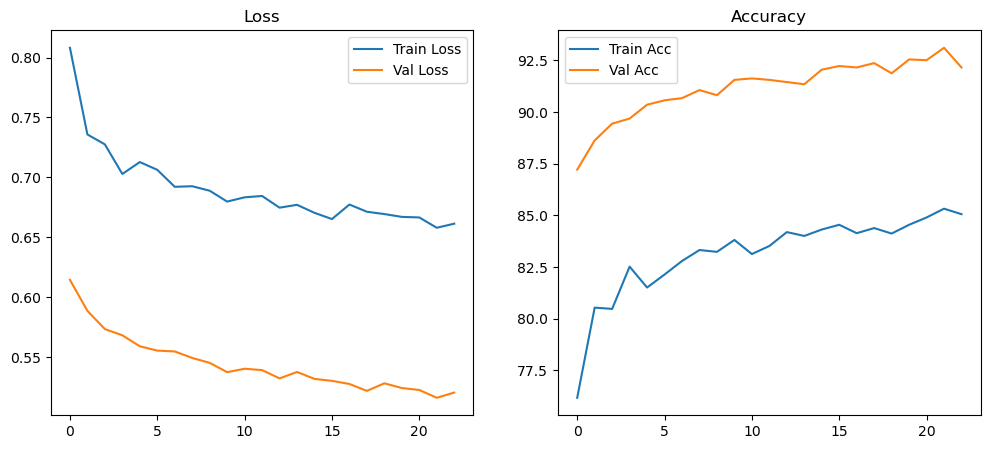

In [17]:
# Plot Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.show()

In [18]:
# Save metrics
with open(metrics_file, "w") as f:
    json.dump(history, f, indent=2)

print(f"Metrics saved to {metrics_file}")
print(f"Best validation loss: {best_val:.4f}")

Metrics saved to ../runs/metrics_efficientnet.json
Best validation loss: 0.5217
